# Inverse Problem: Discovering Thermal Diffusivity in the 1D Heat Equation

This notebook demonstrates a key capability of Physics-Informed Neural Networks (PINNs): solving **inverse problems**. We will tackle the 1D heat equation and, instead of providing all the physical parameters, we will treat the thermal diffusivity, $\alpha$, as an unknown variable. The goal is for the PINN to **discover** the value of $\alpha$ by learning from a small set of sparse observational data.

### Problem Definition & Workflow

1.  **Forward Problem Setup:** We first define a standard "forward" problem for the 1D heat equation with a known, true value of $\alpha$.
    - **PDE:** $\frac{\partial u}{\partial t} = \alpha \frac{\partial^2 u}{\partial x^2}$
    - **Domain:** $x \in [0, 1]$, $t \in [0, 1]$
    - **IC:** $u(x, 0) = \sin(\pi x)$
    - **BCs:** $u(0, t) = 0$, $u(1, t) = 0$

2.  **Generate Synthetic Data:** We solve this forward problem to generate a reference solution. We then sample a small number of points from this solution to simulate sparse, real-world experimental measurements.

3.  **Inverse Problem Setup:** We define a new PINN where the thermal diffusivity, $\alpha$, is a learnable parameter (a `dde.Variable`).

4.  **Training and Discovery:** We train the inverse model using the PDE loss, the IC/BC losses, **and a data loss** from the sparse measurements. The optimizer will adjust the weights of the neural network *and* the value of $\alpha$ simultaneously to minimize the total loss.

5.  **Verification:** Finally, we check if the value of $\alpha$ learned by the model converges to the true value we used to generate the data.



In [2]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for plots
sns.set_style("whitegrid")


### Step 1 & 2: Generate Synthetic Observational Data

To perform an inverse discovery task, we first need data. In a real-world scenario, this would come from experiments. Here, we'll simulate it by creating and solving a **forward problem** with a known, true parameter value.

- We define a true value for the thermal diffusivity, `alpha_true`.
- We build a standard PINN model for the heat equation using this true value.
- We train this model to get an accurate reference solution over the entire domain.



In [ ]:
# Define the true thermal diffusivity for data generation
alpha_true = 0.1 / np.pi

def create_forward_model():
    """Creates and solves the forward problem to generate reference data."""
    geom = dde.geometry.Interval(0, 1)
    timedomain = dde.geometry.TimeDomain(0, 1)
    geomtime = dde.geometry.GeometryXTime(geom, timedomain)

    def pde_forward(x, u):
        du_t = dde.grad.jacobian(u, x, i=0, j=1)
        du_xx = dde.grad.hessian(u, x, i=0, j=0)
        return du_t - alpha_true * du_xx
    
    # Define a robust initial condition function
    def initial_condition_func(x):
        if isinstance(x, np.ndarray):
            sin = np.sin
        else:
            sin = dde.backend.sin
        return sin(np.pi * x[:, 0:1])

    bc_left = dde.DirichletBC(geomtime, lambda x: 0, lambda x, on_boundary: on_boundary and dde.utils.isclose(x[0], 0))
    bc_right = dde.DirichletBC(geomtime, lambda x: 0, lambda x, on_boundary: on_boundary and dde.utils.isclose(x[0], 1))
    ic = dde.IC(geomtime, initial_condition_func, lambda _, on_initial: on_initial)

    data = dde.data.TimePDE(geomtime, pde_forward, [bc_left, bc_right, ic], num_domain=2540, num_boundary=80, num_initial=160)
    net = dde.nn.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")
    model = dde.Model(data, net)
    
    print("Solving forward problem to generate data...")
    model.compile("adam", lr=1e-3)
    model.train(iterations=10000, display_every=5000)
    print("Forward problem solved.")
    return model

# Create and solve the forward model
forward_model = create_forward_model()



Solving forward problem to generate data...
Compiling model...
'compile' took 14.158679 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [7.83e-04, 1.38e-04, 3.81e-02, 6.50e-01]    [7.83e-04, 1.38e-04, 3.81e-02, 6.50e-01]    []  


c:\Users\SUNNIE.GD.WENG\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\autograd\graph.py:824: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:181.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


5000      [1.98e-05, 1.55e-06, 5.11e-06, 5.82e-06]    [1.98e-05, 1.55e-06, 5.11e-06, 5.82e-06]    []  
10000     [9.44e-06, 6.09e-07, 9.39e-07, 1.16e-06]    [9.44e-06, 6.09e-07, 9.39e-07, 1.16e-06]    []  

Best model at step 10000:
  train loss: 1.22e-05
  test loss: 1.22e-05
  test metric: []

'train' took 65.813197 s

Forward problem solved.


### Step 3: Sample Sparse Data from the Reference Solution

With the trained forward model, we can now generate our "experimental" data. We do this by predicting the solution `u(x, t)` at a small number of randomly chosen points within the domain. This simulates having sparse measurements from sensors.

- We create `num_measurements` random points `(x, t)`.
- We use `forward_model.predict()` to get the solution values at these points.
- We package these points and their corresponding values into a `dde.PointSetBC` object. This object will later serve as a boundary condition (a data-driven one) for our inverse problem, forcing the new model's solution to pass through these known points.



In [4]:
# Set the number of measurement points
num_measurements = 50

# Generate random observation points in the domain [0,1] x [0,1]
observe_x = np.random.rand(num_measurements, 2)

# Predict the solution at these points to get the measurement values
observe_u = forward_model.predict(observe_x)

# Optional: Add random noise to simulate real-world measurement errors
# noise_level = 0.01
# observe_u += noise_level * np.std(observe_u) * np.random.randn(*observe_u.shape)

# Create the PointSetBC object, which will enforce the data constraint in the inverse problem
observe_points = dde.PointSetBC(observe_x, observe_u)


### Step 4: Define and Solve the Inverse Problem

This is where we set up the PINN to discover the unknown parameter.

- **Learnable Variable:** We define `alpha_inverse` as a `dde.Variable`. This tells `deepxde` that `alpha_inverse` is a trainable parameter, just like the weights and biases of the neural network. We initialize it with a guess (e.g., `0.0`).
- **Inverse PDE:** The `pde_inverse` function is almost identical to the forward PDE, but it uses the learnable `alpha_inverse` instead of the fixed `alpha_true`.
- **Data Assembly:** We create a new `dde.data.TimePDE` object. Crucially, we add our `observe_points` object to the list of boundary/initial conditions. The loss function will now include a term that measures the difference between the network's prediction and our sparse data, driving the solution to honor these measurements.
- **Training Configuration:**
    - When compiling the model, we must pass our learnable variable to the `external_trainable_variables` argument. This ensures the optimizer knows to update it.
    - We use a `dde.callbacks.VariableValue` callback. This is a utility that records the value of `alpha_inverse` at regular intervals during training, allowing us to visualize its convergence later.
  


In [5]:
# Define the unknown parameter alpha as a dde.Variable.
# We initialize it with a guess, e.g., 0.0
alpha_inverse = dde.Variable(0.0)

def pde_inverse(x, u):
    """PDE residual for the inverse problem with a learnable alpha."""
    du_t = dde.grad.jacobian(u, x, i=0, j=1)
    du_xx = dde.grad.hessian(u, x, i=0, j=0)
    return du_t - alpha_inverse * du_xx

# Reuse the same geometry and IC/BC definitions
geom = dde.geometry.Interval(0, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Define a robust initial condition function again for the inverse problem
def initial_condition_func_inverse(x):
    if isinstance(x, np.ndarray):
        sin = np.sin
    else:
        sin = dde.backend.sin
    return sin(np.pi * x[:, 0:1])

bc_left = dde.DirichletBC(geomtime, lambda x: 0, lambda x, on_boundary: on_boundary and dde.utils.isclose(x[0], 0))
bc_right = dde.DirichletBC(geomtime, lambda x: 0, lambda x, on_boundary: on_boundary and dde.utils.isclose(x[0], 1))
ic = dde.IC(geomtime, initial_condition_func_inverse, lambda _, on_initial: on_initial)

# In the inverse problem, the boundary conditions include the observational data points
data_inverse = dde.data.TimePDE(
    geomtime,
    pde_inverse,
    [bc_left, bc_right, ic, observe_points], # Add the PointSetBC here
    num_domain=2540,
    num_boundary=80,
    num_initial=160,
)

net_inverse = dde.nn.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")

# Glorot normal (also known as Xavier normal initialization) is a weight initialization method
# It initializes weights from a normal distribution with mean=0 and variance=2/(fan_in + fan_out)
# where fan_in is the number of input units and fan_out is the number of output units
# This helps maintain the variance of activations and gradients across layers during training


model_inverse = dde.Model(data_inverse, net_inverse)

# We need to tell the optimizer to train the external variable (alpha) as well
external_trainable_variables = [alpha_inverse]
variable_filename = "variables.dat"
variable_callback = dde.callbacks.VariableValue(
    external_trainable_variables, period=1000, filename=variable_filename
)

print("\nSolving inverse problem...")
model_inverse.compile("adam", lr=1e-3, external_trainable_variables=external_trainable_variables)
losshistory, train_state = model_inverse.train(iterations=20000, callbacks=[variable_callback])



Solving inverse problem...
Compiling model...
'compile' took 0.000182 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [4.55e-02, 1.01e-02, 5.90e-03, 3.59e-01, 3.80e-01]    [4.55e-02, 1.01e-02, 5.90e-03, 3.59e-01, 3.80e-01]    []  
1000      [1.05e-03, 8.46e-05, 1.56e-04, 4.18e-04, 2.06e-04]    [1.05e-03, 8.46e-05, 1.56e-04, 4.18e-04, 2.06e-04]    []  
2000      [8.96e-05, 5.74e-06, 3.38e-05, 2.80e-05, 9.59e-06]    [8.96e-05, 5.74e-06, 3.38e-05, 2.80e-05, 9.59e-06]    []  
3000      [6.46e-05, 5.15e-06, 2.36e-05, 1.88e-05, 5.50e-06]    [6.46e-05, 5.15e-06, 2.36e-05, 1.88e-05, 5.50e-06]    []  
4000      [4.78e-05, 3.32e-06, 1.72e-05, 1.36e-05, 3.44e-06]    [4.78e-05, 3.32e-06, 1.72e-05, 1.36e-05, 3.44e-06]    []  
5000      [3.60e-05, 1.68e-06, 1.19e-05, 8.30e-06, 2.04e-06]    [3.60e-05, 1.68e-06, 1.19e-05, 8.30e-06, 2.04e-06]    []  
6000      [2.82e-05, 7.18e-07, 7.64e-06

### Step 5: Check the Result

After the inverse model is trained, we can check how well the PINN performed its discovery task.

- **Final Value:** We compare the final value of `alpha_inverse` to the `alpha_true` we used to generate the data.
- **Convergence Plot:** We read the `variables.dat` file saved by our callback to plot the value of `alpha` at each recorded epoch. This visualization is crucial to confirm that the parameter has converged to a stable value and didn't just stop at a random point.



True value of alpha: 0.031831
Learned value of alpha: 0.031694


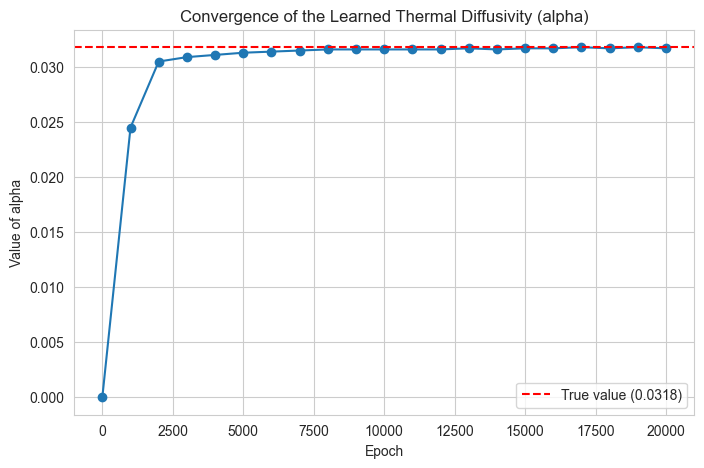

In [38]:
# Print the final learned value against the true value
print(f"\nTrue value of alpha: {alpha_true:.6f}")
learned_alpha = np.array(alpha_inverse.data.cpu())
print(f"Learned value of alpha: {learned_alpha:.6f}")

# Plot the convergence of alpha
lines = open(variable_filename, "r").readlines()

# Parse the alpha values from the file format
# The format is: "epoch [value]" so we need to extract the value from the brackets
import re

alpha_history = []
for line in lines:
    # Use regex to extract the value between brackets
    match = re.search(r'\[(.*?)\]', line.strip())
    if match:
        alpha_history.append(float(match.group(1)))

alpha_history = np.array(alpha_history)


plt.figure(figsize=(8, 5))
# The x-axis is the epoch number, which is the iteration number (0, 1000, 2000...)
plt.plot(np.arange(len(alpha_history)) * 1000, alpha_history, marker='o', linestyle='-')
plt.axhline(y=alpha_true, color='r', linestyle='--', label=f'True value ({alpha_true:.4f})')
plt.xlabel("Epoch")
plt.ylabel("Value of alpha")
plt.title("Convergence of the Learned Thermal Diffusivity (alpha)")
plt.legend()
plt.grid(True)
plt.show()
